# Training a model

This notebook takes input TTrees that contain event-level branches and classifies between different groups of events.

## Preparing the dataframe

In [1]:
import os, sys
import numpy as np
import uproot
import pandas as pd
import json
from IPython.display import display, Markdown, HTML
import time
from datetime import timedelta
notebook_start_time = time.time()
from rich.progress import Progress, BarColumn, TaskProgressColumn

#indir = '../ROOT_FILES/trees/forTraining'
indir = '../ROOT_FILES/trees'
RESET      = '\033[0m'
RED        = '\033[0;31m'
RED_BOLD   = '\033[1;31m'
GREEN      = '\033[0;32m'
GREEN_BOLD = '\033[1;32m'
BLUE       = '\033[0;34m'
BLUE_BOLD  = '\033[1;34m'

run = "Run2"
fs  = "2LOS"

#modelname = 'QCD-vs-VLLD Run3 2LSS (Aug13)'
#modelname = 'Wjets-vs-VLLD Run2 2lSS (Aug13)'
modelname = 'Top-vs-VLLD Run2 2LOS (Oct09)'
#modelname = f'DYjets-vs-VLLD {run} {fs} (Oct09)'

print('Modules loaded.')

Modules loaded.


In [2]:
#Given a TFile, read its branches into a dataframe.
def read_file_into_df(filepath, truth, step_size=100000):
    if not os.path.exists(filepath):
        print(f"{RED_BOLD}File not found: {filepath}{RESET}")
        return pd.DataFrame()

    filename = filepath.split('/')[-1]
    sample = filename.split("_")[1]
    subsample = "_".join(filename.split("_")[2:])
    if subsample.endswith(".root"): subsample = subsample[:-5]

    with uproot.open(filepath) as tfile:
        if "myEvents" not in tfile:
            print(f"Warning: 'myEvents' tree not found in {filepath}. Skipping.")
            return pd.DataFrame()

        ttree = tfile["myEvents"]
        total_entries = ttree.num_entries
        if total_entries == 0:
            print(f"Warning: 'myEvents' tree in {filepath} is empty. Skipping.")
            return pd.DataFrame()

        total_batches = (total_entries + step_size - 1) // step_size
        dfs = []

        with Progress("[progress.description]{task.description}", BarColumn(), TaskProgressColumn()) as progress:
            task = progress.add_task(f"Reading {sample}_{subsample}", total=total_batches)
            for batch in ttree.iterate(ttree.keys(), step_size=step_size, library="pd"):
                batch["truth"] = truth
                batch["sample"] = sample
                batch["subsample"] = subsample
                dfs.append(batch)
                progress.update(task, advance=1)

    df = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()
    print(f"{BLUE}Loaded {sample}_{subsample}: {len(df)} entries{RESET}")
    return df

def prepare_df(jobname, samples, truth, nmax=None):
    #print(f'Picking files from {os.path.join(indir, jobname)}')
    dfout = pd.DataFrame()
    files = os.listdir(os.path.join(indir, jobname))

    for f in files:
        if not any(s in f for s in samples): continue
        filepath = os.path.join(indir, jobname, f)
        print(f"Reading {filepath} ...")
        df = read_file_into_df(filepath, truth)
        if df.empty:
            print(f"{RED}Warning: Skipping empty file: {f}{RESET}")
            continue
        if nmax is not None and len(df) > nmax: df = df.sample(frac=1).reset_index(drop=True).head(nmax)
        dfout = pd.concat([dfout, df], ignore_index=True)

    return dfout

print('Functions loaded.')

Functions loaded.


### Reading the trees into dataframes

In [3]:
%%time

jobs = []
if 'Run2' in modelname:
    jobs = [
        #'tree_baseline_2016preVFP_UL',
        #'tree_baseline_2016postVFP_UL',
        #'tree_baseline_2017_UL',
        'tree_2LOS_baseline_2018_UL'
    ]
elif 'Run3' in modelname:
    jobs = [
        'tree_baseline_Run3Summer22',
        'tree_baseline_Run3Summer22EE',
        'tree_baseline_Run3Summer23',
        'tree_baseline_Run3Summer23BPix',
    ]


sigsamples = ['VLLD-mu_200', 'VLLD-mu_300', 'VLLD-mu_400', 'VLLD-mu_600', 'VLLD-mu_800',
              'VLLD-ele_200', 'VLLD-ele_300', 'VLLD-ele_400', 'VLLD-ele_600', 'VLLD-ele_800']
if '2LOS' in modelname:
    sigsamples = ['VLLD-mu_200', 'VLLD-mu_300', 'VLLD-mu_400', 'VLLD-mu_600', 'VLLD-mu_800', 'VLLD-mu_1000', 'VLLD-mu_1200'
                  'VLLD-ele_200','VLLD-ele_300','VLLD-ele_400','VLLD-ele_600','VLLD-ele_800','VLLD-ele_1000','VLLD-ele_1200']

### backgrounds:
bkgsamples = []
if '2LOS' in modelname:
    if "Top" in modelname:   bkgsamples = ['TT_TTto2L2Nu', 'TT_TTtoLNu2Q']
    if "DY" in modelname:    bkgsamples = ["DYto2L_50toInf"]
else:
    if "QCD" in modelname:   bkgsamples = ['QCDMu', 'QCDEM']
    if "Wjets" in modelname: bkgsamples = ['WtoLNu_Inclusive', 'WGtoLNuG_Inclusive','WGtoLNuG_100to200','WGtoLNuG_10to100']
    if "Top" in modelname:   bkgsamples = ['TT_TTto2L2Nu', 'TT_TTtoLNu2Q'
                                           "ST_s-channel", "ST_t-channel-antitop", "ST_t-channel-top",
                                           "ST_TbarBQ", "ST_TbarBtoLminusNuB", "ST_TBbarQ", "ST_TBbartoLplusNuBbar"]
    if "DY" in modelname:    bkgsamples = ["DYto2L_10to50", "DYto2L_50toInf", "DYGToLLG_Inclusive", "DYGToLLG_M4to50-PT10to100", "DYGToLLG_M50-PT10to100"]
    
### Preparing dataframes:
bkgdf = pd.concat([prepare_df(j, bkgsamples, 0) for j in jobs])
print(f"{BLUE}Background ready! Entries = {bkgdf.shape[0]}{RESET}\n")

sigdf = pd.concat([prepare_df(j, sigsamples, 1) for j in jobs])
print(f"{BLUE}Signal ready! Entries = {sigdf.shape[0]}{RESET}\n")

print(f'{GREEN_BOLD}Done reading samples.{RESET}')
os.makedirs(f'trained_models/{modelname}', exist_ok=True)
print('Ready to proceed.')

Output()

Reading ../ROOT_FILES/trees/tree_2LOS_baseline_2018_UL/tree_TT_TTto2L2Nu.root ...


Output()

Loaded TT_TTto2L2Nu: 7204864 entries
Reading ../ROOT_FILES/trees/tree_2LOS_baseline_2018_UL/tree_TT_TTtoLNu2Q.root ...


Loaded TT_TTtoLNu2Q: 27689 entries


Output()

Background ready! Entries = 7232553

Reading ../ROOT_FILES/trees/tree_2LOS_baseline_2018_UL/tree_VLLD-ele_1000.root ...


Loaded VLLD-ele_1000: 9049 entries
Reading ../ROOT_FILES/trees/tree_2LOS_baseline_2018_UL/tree_VLLD-ele_1200.root ...


Output()

Output()

Loaded VLLD-ele_1200: 8662 entries
Reading ../ROOT_FILES/trees/tree_2LOS_baseline_2018_UL/tree_VLLD-ele_300.root ...


Output()

Loaded VLLD-ele_300: 7260 entries
Reading ../ROOT_FILES/trees/tree_2LOS_baseline_2018_UL/tree_VLLD-ele_400.root ...


Output()

Loaded VLLD-ele_400: 8565 entries
Reading ../ROOT_FILES/trees/tree_2LOS_baseline_2018_UL/tree_VLLD-ele_600.root ...


Output()

Loaded VLLD-ele_600: 8483 entries
Reading ../ROOT_FILES/trees/tree_2LOS_baseline_2018_UL/tree_VLLD-ele_800.root ...


Loaded VLLD-ele_800: 8939 entries
Reading ../ROOT_FILES/trees/tree_2LOS_baseline_2018_UL/tree_VLLD-mu_1000.root ...


Output()

Loaded VLLD-mu_1000: 14237 entries
Reading ../ROOT_FILES/trees/tree_2LOS_baseline_2018_UL/tree_VLLD-mu_200.root ...


Output()

Output()

Loaded VLLD-mu_200: 19039 entries
Reading ../ROOT_FILES/trees/tree_2LOS_baseline_2018_UL/tree_VLLD-mu_300.root ...


Loaded VLLD-mu_300: 10717 entries
Reading ../ROOT_FILES/trees/tree_2LOS_baseline_2018_UL/tree_VLLD-mu_400.root ...


Output()

Output()

Loaded VLLD-mu_400: 12010 entries
Reading ../ROOT_FILES/trees/tree_2LOS_baseline_2018_UL/tree_VLLD-mu_600.root ...


Output()

Loaded VLLD-mu_600: 13657 entries
Reading ../ROOT_FILES/trees/tree_2LOS_baseline_2018_UL/tree_VLLD-mu_800.root ...


Loaded VLLD-mu_800: 14034 entries
Signal ready! Entries = 134652

Done reading samples.
Ready to proceed.
CPU times: user 1min 14s, sys: 4.68 s, total: 1min 19s
Wall time: 1min 23s


In [4]:
nsig_og = sigdf.shape[0]
nbkg_og = bkgdf.shape[0]
print(f'Signal: {nsig_og}')
print(f'Background: {nbkg_og}')

max_allowed_bkg = 100000 #2LSS
if '2LOS' in modelname: 150000

#Filtering:
filter = 'lep0_iso < 1.0 and lep1_iso < 1.0'
if 'QCD' not in modelname: filter = 'lep0_iso < 0.15 and lep1_iso < 0.15'
if 'DY' in modelname:      filter += " and not (dilep_mass > 76 and dilep_mass < 106) and channel == 3" #ee channel only
if '2LOS' in modelname:    filter += " and (channel == 0 or channel == 3)" #ee and mumu channel only

sigdf = sigdf#.query(filter)
bkgdf = bkgdf#.query(filter)
if 'qcd' not in modelname: bkgdf = bkgdf.sample(n=min(max_allowed_bkg, len(bkgdf)), random_state=42).reset_index(drop=True)

#Concatenating and filtering:
df = pd.concat([sigdf, bkgdf])
df = df.sample(frac=1).reset_index(drop=True) #randomizing rows
nsig = df[df['truth'] == 1].shape[0]
nbkg = df[df['truth'] == 0].shape[0]

print(f'Final signal and background: {BLUE_BOLD}{nsig}, {nbkg}{RESET}')

sample_dict = {
    sample: {sub: int(len(subdf)) for sub, subdf in sdf.groupby('subsample')}
    for sample, sdf in df.groupby('sample')
}

print(json.dumps(sample_dict, indent=2))

Signal: 134652
Background: 7232553
Final signal and background: 134652, 100000
{
  "TT": {
    "TTto2L2Nu": 99628,
    "TTtoLNu2Q": 372
  },
  "VLLD-ele": {
    "1000": 9049,
    "1200": 8662,
    "300": 7260,
    "400": 8565,
    "600": 8483,
    "800": 8939
  },
  "VLLD-mu": {
    "1000": 14237,
    "200": 19039,
    "300": 10717,
    "400": 12010,
    "600": 13657,
    "800": 14034
  }
}


### Filtering the dataframe

In [5]:
df

,channel,trigger,nlep,njet,nfatjet,nbjet,lep0_pt,lep0_eta,lep0_phi,lep0_iso,...,wt_bjet_up,weight_up,wt_leptonSF_down,wt_trig_down,wt_pileup_down,wt_bjet_down,weight_down,truth,sample,subsample
0,0,0,2,2,0,0,86.749466,0.091400,-1.927490,0.019007,...,1.000000,0.924803,0.976940,0.997170,1.064387,1.0,1.036899,1,VLLD-mu,200
1,0,0,2,3,2,0,466.995819,0.188416,-2.123535,0.023564,...,1.000000,0.918957,0.976940,0.997170,1.071759,1.0,1.044081,1,VLLD-mu,800
2,3,1,2,1,0,1,71.020035,-2.159180,0.169617,0.003698,...,1.000000,0.898798,0.958731,0.998671,1.074573,1.0,1.028858,0,TT,TTto2L2Nu
3,0,0,2,1,0,0,121.106041,1.427246,-0.984619,0.011066,...,1.000000,0.971362,0.878475,0.946800,1.054232,1.0,0.876847,0,TT,TTto2L2Nu
4,1,2,2,1,0,0,67.923515,-1.867188,2.247070,0.006548,...,1.000000,0.976520,0.944620,0.997908,0.978336,1.0,0.922222,0,TT,TTto2L2Nu
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234647,2,2,2,0,0,0,79.071648,-0.653687,2.854980,0.004164,...,1.000000,0.975192,0.941425,0.997908,0.978336,1.0,0.919103,0,TT,TTto2L2Nu
234648,0,0,2,1,0,1,81.846420,-0.351196,-0.786255,0.017594,...,1.000000,0.915213,0.960147,0.997556,1.064387,1.0,1.019471,0,TT,TTto2L2Nu
234649,3,1,2,2,2,1,617.948059,0.340454,-2.981445,0.019229,...,1.000000,1.007216,0.976199,0.997925,1.002303,1.0,0.976416,1,VLLD-ele,1000
234650,0,0,2,2,1,0,658.166077,-0.589111,-2.088379,0.001275,...,1.000000,1.057879,0.976940,0.997170,0.920997,1.0,0.897212,1,VLLD-mu,1000


In [6]:
df.columns

Index(['channel', 'trigger', 'nlep', 'njet', 'nfatjet', 'nbjet', 'lep0_pt',
       'lep0_eta', 'lep0_phi', 'lep0_iso', 'lep0_sip3d', 'lep0_mt', 'lep1_pt',
       'lep1_eta', 'lep1_phi', 'lep1_iso', 'lep1_sip3d', 'lep1_mt', 'dilep_pt',
       'dilep_eta', 'dilep_phi', 'dilep_mass', 'dilep_mt', 'dilep_deta',
       'dilep_dphi', 'dilep_dR', 'dilep_ptratio', 'LT', 'LTplusMET', 'HT',
       'HTfat', 'HTplusMET', 'HTfatplusMET', 'STvis', 'STvisfat', 'ST',
       'STfat', 'HTMETllpt', 'HTfatMETllpt', 'STfrac', 'metpt', 'metphi',
       'dphi_metlep0', 'dphi_metlep1', 'dphi_metdilep', 'dphi_metlep_max',
       'dphi_metlep_min', 'jec', 'jer', 'wt_leptonSF', 'wt_trig', 'wt_pileup',
       'wt_bjet', 'weight', 'wt_leptonSF_up', 'wt_trig_up', 'wt_pileup_up',
       'wt_bjet_up', 'weight_up', 'wt_leptonSF_down', 'wt_trig_down',
       'wt_pileup_down', 'wt_bjet_down', 'weight_down', 'truth', 'sample',
       'subsample'],
      dtype='object')

### Exploring the variables

In [7]:
import matplotlib.pyplot as plt
import math
os.makedirs(f'trained_models/{modelname}/before_training', exist_ok=True)

def latexname(var, alias): return alias.get(var, var) #Either get the latexname, or return the default name.

def get_bins(var, data):
    vmax = data.max()
    vmin = data.min()
    bins = 'auto'
    if var.startswith('n') or var in ['nbjet', 'nlep', 'njet', 'nfatjet']: bins = np.arange(vmin - 0.5, vmax + 1.5, 1)
    if any(k in var for k in ('pt', 'mt', 'mass', 'HT', 'LT', 'ST')): bins = np.arange(0, 1050, 50)
    if any(k in var for k in ('STfrac', 'ptratio')): bins = 'auto'
    return bins

def plot_in_group(listvar, figname, suptitle=None, alias=None, ncols=5, vert=2.5, size=16):
    num_vars = len(listvar)
    nrows = math.ceil(num_vars / ncols)
    vertical_size = nrows * vert
    
    fig, ax = plt.subplots(nrows, ncols, figsize=(size, vertical_size))
    ax = ax.flatten()
    
    decorate_hist = {
        'histtype':'step',
        'linewidth':1.5,
        'density':True,
        'log':False
    }
    
    for i, var in enumerate(listvar):        
        sigdata = df[df['truth'] == 1][var]
        bkgdata = df[df['truth'] == 0][var]
        bins = get_bins(var, pd.concat([sigdata, bkgdata]))        
        nsig = len(sigdata)
        nbkg = len(bkgdata)
        
        ax[i].hist(sigdata, bins=bins, label=f'sig [{nsig}]', color='xkcd:green', **decorate_hist)
        ax[i].hist(bkgdata, bins=bins, label=f'bkg [{nbkg}]', color='xkcd:blue',  **decorate_hist)
        #if any(k in var for k in ['pt', 'HT', 'LT', 'ST']) and var not in 'STfrac': ax[i].set_yscale('log')
        
        if not alias: ax[i].set_title(var, fontsize=10)
        else: ax[i].set_title(latexname(var, alias), fontsize=10)
        ax[i].legend(loc='best', fontsize=8)
        ax[i].tick_params(axis='both', labelsize=6)
    
    for j in range(i+1, len(ax)): fig.delaxes(ax[j])

    if suptitle: fig.suptitle(suptitle, fontsize=12)
    
    plt.tight_layout()
    plt.savefig(f'trained_models/{modelname}/before_training/{figname}.png', dpi=300)
    plt.show()

print('Ready to plot!')

Ready to plot!


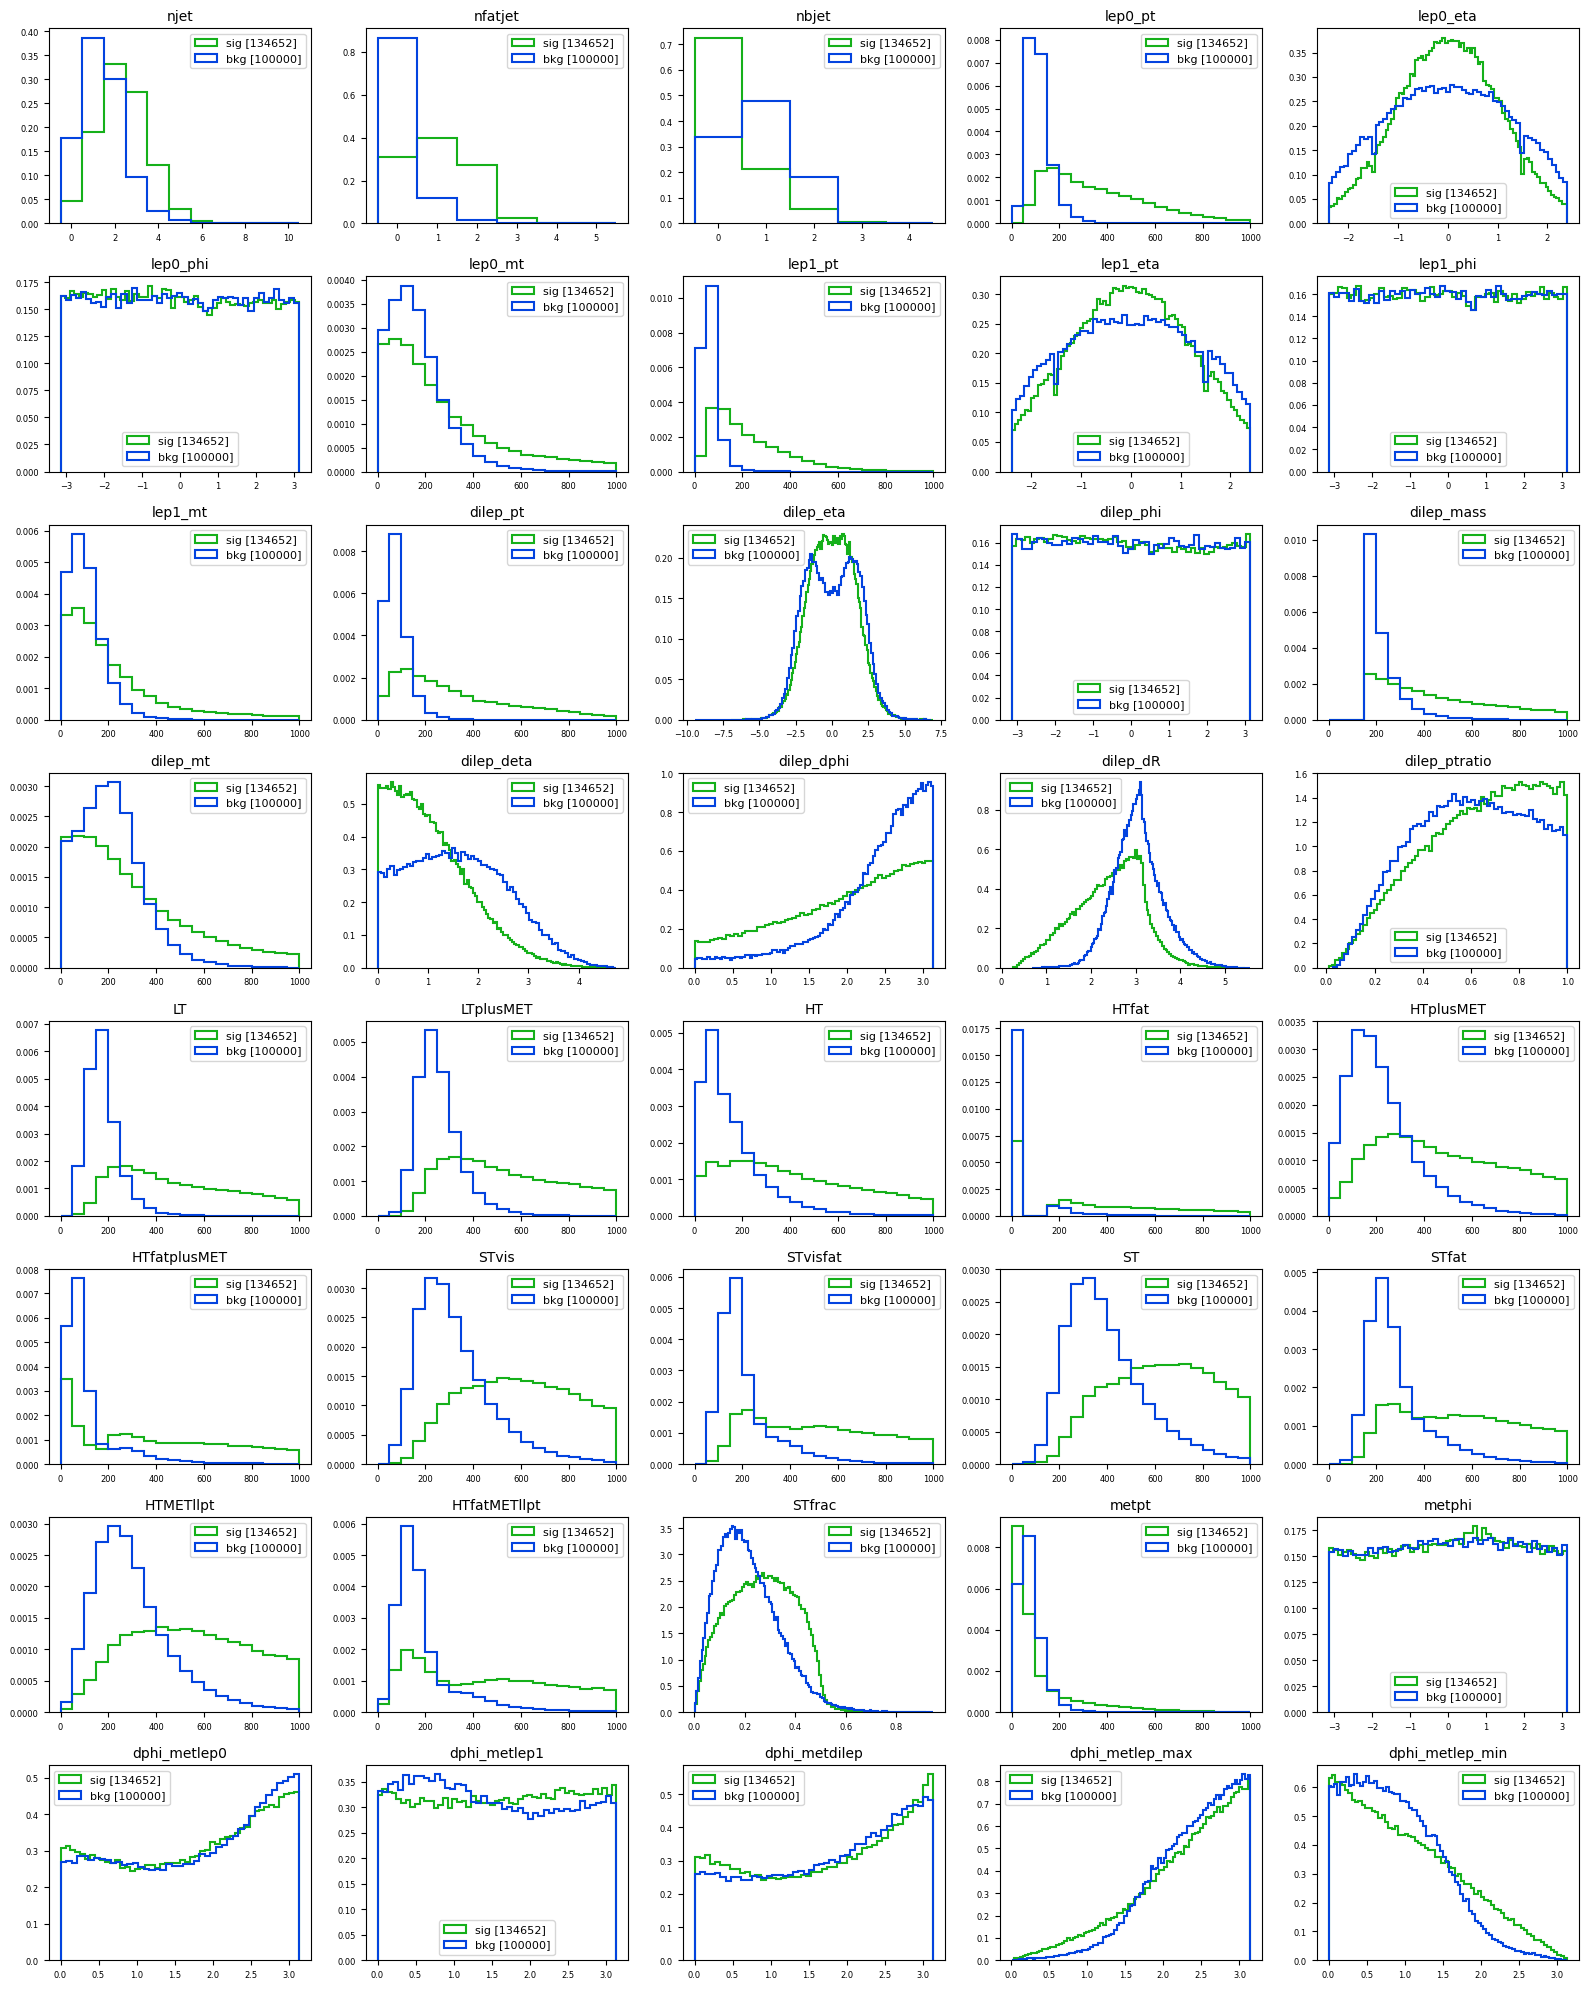

CPU times: user 15.3 s, sys: 201 ms, total: 15.5 s
Wall time: 15.6 s


In [8]:
%%time 
allvar = list(df.keys())

skipvar = ['channel', 'nlep', 'lep0_iso', 'lep0_sip3d', 'lep1_iso', 'lep1_sip3d',
           'wt_leptonSF',      'wt_trig',      'wt_bjet',        'wt_pileup',    'weight',
           'wt_leptonSF_up',   'wt_trig_up',   'wt_pileup_up',   'wt_bjet_up',   'weight_up',
           'wt_leptonSF_down', 'wt_trig_down', 'wt_pileup_down', 'wt_bjet_down', 'weight_down',
           'truth', 'sample', 'subsample', 'trigger', 'jec', 'jer',
          ]
plotvar = [var for var in allvar if var not in skipvar]

plot_in_group(plotvar, 'exploring_all_var')

### Deciding which variables to train on

The following input variables are chosen.
nbjet               nbjet
dilep_ptratio       $p_{T1}/p_{T0}$
LTplusMET           $L_{T}+p_{T}^{\text{  miss}}$
STvis               STvis
STfrac              $S_{T}^{\text{  frac}}$
metpt               $p_{T}^{\text{  miss}}$


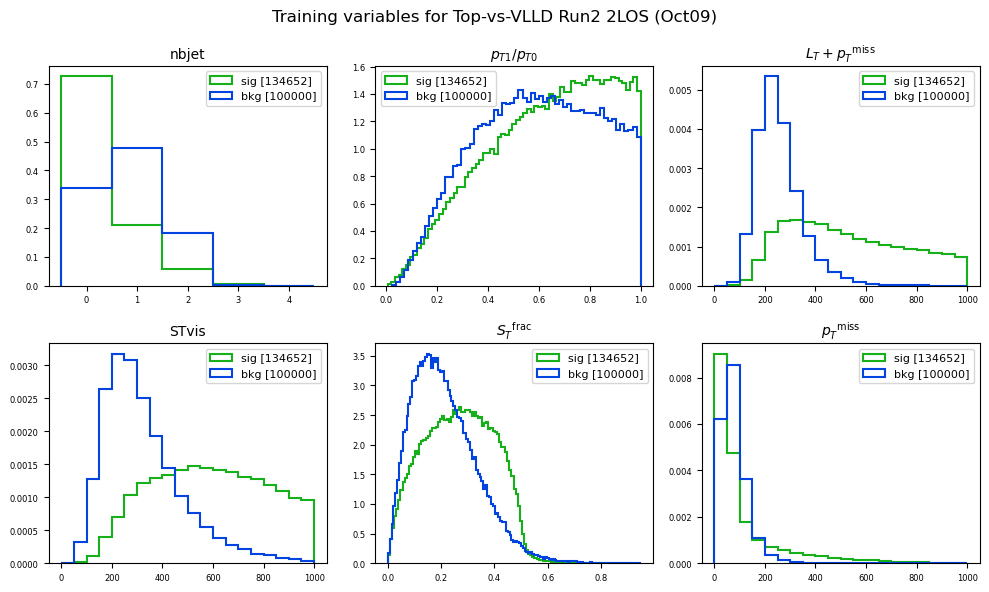

In [9]:
train_var = []

if '2LOS' in modelname:
    if 'Top' in modelname:   train_var = ['nbjet','dilep_ptratio','LTplusMET','STvis','STfrac','metpt']
    if 'DY' in modelname:    train_var = ['njet','dilep_eta','dilep_dR','ST','STfrac','dphi_metlep_max']
elif '2LSS' in modelname:
    if 'QCD' in modelname:   train_var = ['njet','dilep_dR','dilep_ptratio','LTplusMET','ST','STfrac','metpt','dphi_metdilep','dphi_metlep_min']
    if 'Wjets' in modelname: train_var = ['njet','dilep_mt','dilep_ptratio','dilep_dR','LTplusMET','STfrac']
    if 'Top' in modelname:   train_var = ['nbjet','dilep_ptratio','LTplusMET','ST','STfrac','dphi_metlep0',]
    if 'DY' in modelname:    train_var = ['njet','lep0_eta','lep1_eta','dilep_mt','LTplusMET','metpt']
else: print('Error: Pick training variables first!')
    
alias_ = {
    'njet':            r'$N_{\text{J}}$',
    'lep0_eta':        r'$\eta (L_0)$',
    'lep1_eta':        r'$\eta (L_1)$',
    'lep0_mt':         r'$m_{T} (L_0)$',
    'lep1_mt':         r'$m_{T} (L_1)$',
    'dilep_pt':        r'$p_{T}^{\text{  LL}}$',
    'dilep_mt':        r'$M_{T}^{\text{  LL}}$',
    'dilep_dR':        r'$\Delta R(L_{0}, L_{1})$',
    'dilep_dphi':      r'$\Delta\phi(L_{0}, L_{1})$',
    'dilep_deta':      r'$\Delta\eta(L_{0}, L_{1})$',
    'dilep_ptratio':   r'$p_{T1}/p_{T0}$',
    'HTMETllpt':       r'$H_{T}+p_{T}^{\text{  miss}}+ p_T^{\text{  LL}}$',
    'HT':              r'$H_{T}$',
    'LT':              r'$L_{T}$',
    'LTplusMET':       r'$L_{T}+p_{T}^{\text{  miss}}$',
    'ST':              r'$S_{T}$',
    'STfrac':          r'$S_{T}^{\text{  frac}}$',
    'dphi_metlep0':    r'$\Delta\phi(L_{0}, p_{T}^{\text{  miss}})$',
    'dphi_metlep1':    r'$\Delta\phi(L_{1}, p_{T}^{\text{  miss}})$',
    'dphi_metdilep':   r'$\Delta\phi(LL, p_{T}^{\text{  miss}})$',
    'dphi_metlep_max': r'$max\{\Delta\phi(L, p_{T}^{\text{  miss}})\}$',
    'dphi_metlep_min': r'$min\{\Delta\phi(L, p_{T}^{\text{  miss}})\}$',
    'metpt':           r'$p_{T}^{\text{  miss}}$',
    'metphi':          r'$\phi^{\text{  miss}}$',
} #Uses these names in plot. If not mentioned here, uses the dafault name.

print('The following input variables are chosen.')
for var in train_var: print(f"{var:<20}{latexname(var, alias_)}")

plot_in_group(train_var, 'training_varriables', suptitle=f'Training variables for {modelname}', alias=alias_, ncols=3, vert=3, size=10)

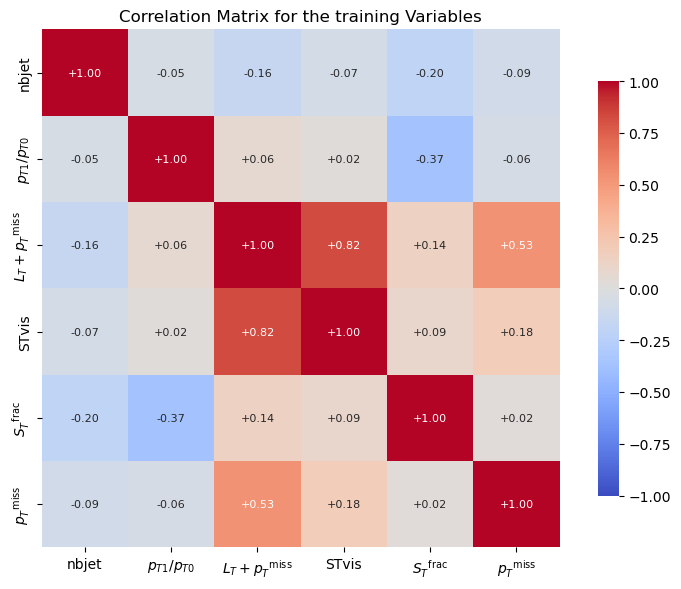

In [10]:
import seaborn as sns

correlation_data = df[train_var]
correlation_matrix = correlation_data.corr()

fig, ax = plt.subplots(figsize=(8, 6))

annot_values = correlation_matrix.map(lambda x: f"{x:+.2f}")
sns.heatmap(correlation_matrix, annot=annot_values, fmt='', cmap='coolwarm', square=True, vmin=-1, vmax=1,
            cbar_kws={"shrink": .8}, ax=ax, annot_kws={"size": 8},
            xticklabels=[latexname(var, alias_) for var in train_var],
            yticklabels=[latexname(var, alias_) for var in train_var])

ax.set_title('Correlation Matrix for the training Variables', fontsize=12)

plt.tight_layout()
plt.savefig(f'trained_models/{modelname}/before_training/correlation_trainvar.png', dpi=300, bbox_inches='tight')
plt.show()

## Preparing the Neural Network

In [11]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc
from sklearn.utils.class_weight import compute_class_weight
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras import layers

print("Modules loaded.")

2025-10-10 00:27:49.871270: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Modules loaded.


### Training and testing dataset

In [12]:
df = df.sample(frac=1).reset_index(drop=True)
df_train, df_test = train_test_split(df, test_size=0.3, stratify=df['truth'])

#Randomizing again:
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_test  = df_test.sample(frac=1).reset_index(drop=True)

nsig_train = len(df_train.query('truth == 1'))
nsig_test  = len(df_test.query('truth == 1'))
nbkg_train = len(df_train.query('truth == 0'))
nbkg_test  = len(df_test.query('truth == 0'))

print(f'Statistics:')
print(f'nSig split into train and test: {nsig_train}, {nsig_test}')
print(f'nBkg split into train and test: {nbkg_train}, {nbkg_test}')

Statistics:
nSig split into train and test: 94256, 40396
nBkg split into train and test: 70000, 30000


### Min-max scaling

In [13]:
def FindMinMax(X, modelname):
    # Calculate min and max values
    maxval = X.max(axis=0)
    minval = X.min(axis=0)
    print('\n' + '-' * 25)
    print("Min Values found: ", minval)
    print("Max Values found: ", maxval)
    
    # Save min and max values to separate text files without headers
    np.savetxt(f'trained_models/{modelname}/scaling_parameters_min.txt', minval, fmt='%.6f')
    np.savetxt(f'trained_models/{modelname}/scaling_parameters_max.txt', maxval, fmt='%.6f')

def ApplyMinMax(X, min_filename, max_filename):
    minval = np.loadtxt(min_filename)
    maxval = np.loadtxt(max_filename)
    #print('Min from txt: ', minval)
    #print('Max from txt: ', maxval)
    ## Calculate the difference
    diff = maxval - minval
    normed_X = X.copy()    
    nonconst = np.where(diff != 0)[0] # Scale the data only for non-constant columns
    normed_X[:, nonconst] = 2 * ((X[:, nonconst] - minval[nonconst]) / diff[nonconst]) - 1.0
    return normed_X

print('Functions for min-max scaling ready.')

Functions for min-max scaling ready.


In [14]:
#Numpy arrays that go into the training and testing:
X_train= df_train[train_var].values
y_train= df_train['truth'].values
X_test = df_test[train_var].values
y_test = df_test['truth'].values

FindMinMax(X_train, modelname)

X_train = ApplyMinMax(X_train, f'trained_models/{modelname}/scaling_parameters_min.txt', f'trained_models/{modelname}/scaling_parameters_max.txt')
X_test  = ApplyMinMax(X_test,  f'trained_models/{modelname}/scaling_parameters_min.txt', f'trained_models/{modelname}/scaling_parameters_max.txt')


-------------------------
Min Values found:  [0.00000000e+00 1.25132538e-02 5.52118988e+01 4.43852158e+01
 2.78677238e-04 1.44224763e-01]
Max Values found:  [4.00000000e+00 9.99989212e-01 4.75990479e+03 6.32054102e+03
 9.22770083e-01 2.54807275e+03]


In [15]:
column_index = 1  # Replace 'i' with the column index you're interested in
print(np.min(X_train[:, column_index]), np.max(X_train[:, column_index]))

-0.9999994858855833 1.0000004284849364


### Defining the model parameters

In [16]:
n_features = X_train.shape[1]
epochs_, batch_ = 25, 128
if '2LOS' in modelname:
    if 'Top' in modelname: epochs_, batch_ = 100, 1024
    if 'DY' in modelname: epochs_, batch_ = 25, 1024
else:
    if 'Wjets' in modelname: epochs_, batch_ = 50, 128
    if 'Top' in modelname: epochs_, batch_ = 50, 256
    if 'DY' in modelname: epochs_, batch_ = 50, 512

model = keras.Sequential([
    layers.Input(shape=(n_features,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

### Training

In [17]:
%%time

# Calculate weights according to truth information
classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, weights))

# Early stopping
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6
    )
]

history = model.fit(
    X_train, y_train,
    epochs=epochs_,
    batch_size=batch_,
    validation_data=(X_test, y_test),
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

model.save(f'trained_models/{modelname}/model_{modelname}.keras')
print('Training complete!\n')

Epoch 1/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7952 - loss: 0.4622 - val_accuracy: 0.8767 - val_loss: 0.3069 - learning_rate: 0.0010
Epoch 2/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8911 - loss: 0.2611 - val_accuracy: 0.8975 - val_loss: 0.2454 - learning_rate: 0.0010
Epoch 3/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8987 - loss: 0.2371 - val_accuracy: 0.8953 - val_loss: 0.2427 - learning_rate: 0.0010
Epoch 4/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9018 - loss: 0.2303 - val_accuracy: 0.9021 - val_loss: 0.2320 - learning_rate: 0.0010
Epoch 5/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9032 - loss: 0.2271 - val_accuracy: 0.9053 - val_loss: 0.2272 - learning_rate: 0.0010
Epoch 6/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9038 - loss: 0.2253 - val_accuracy: 0.9020 - val_loss: 0.2317 - learning_rate: 0.0010
Epoch 7/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9045 - loss: 0.

In [18]:
from io import StringIO

info_filename = f'trained_models/{modelname}/info_{modelname}.txt'

info = []
info.append(f'Model Name: {modelname}')
info.append(f'Signal and Background before filtering: {nsig}, {nbkg}')
info.append(f'Signal in training: {nsig_train}')
info.append(f'Signal in testing: {nsig_test}')
info.append(f'Background in training: {nbkg_train}')
info.append(f'Background in testing: {nbkg_test}')
info.append(f'Training Variables: {train_var}')
info.append(f'Number of Epochs: {epochs_}')
info.append(f'Batch Size: {batch_}')
info.append('\nModel Summary:\n')

model.summary()
buffer = StringIO()
model.summary(print_fn=lambda x: buffer.write(x + '\n'))
model_summary = buffer.getvalue()
info.append(model_summary)

# Write information to file
with open(info_filename, 'w') as f:
    for line in info:
        f.write(line + '\n')

print(f'Information saved to {info_filename}')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,685 (30.02 KB)

 Trainable params: 2,561 (10.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,124 (20.02 KB)

Information saved to trained_models/Top-vs-VLLD Run2 2LOS (Oct09)/info_Top-vs-VLLD Run2 2LOS (Oct09).txt


### Loss and accuracy

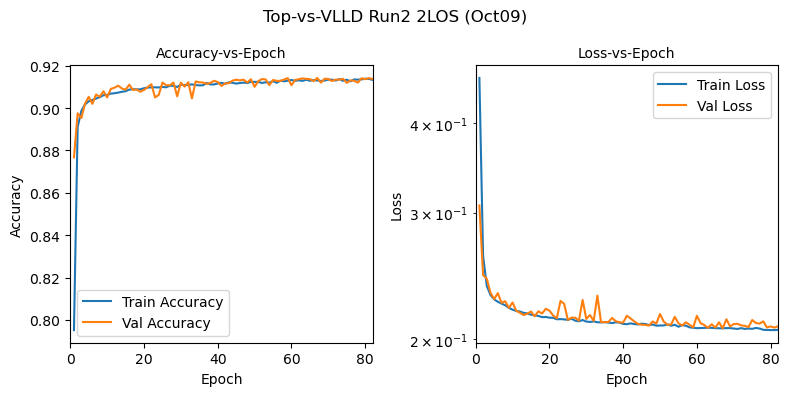

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
epochs_run = len(history.history['loss'])

# Subplot 1: accuracy vs epoch
ax[0].plot(range(1, epochs_run + 1), history.history['accuracy'],     label='Train Accuracy')
ax[0].plot(range(1, epochs_run + 1), history.history['val_accuracy'], label='Val Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_xlim(0, epochs_run)
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy-vs-Epoch', fontsize=10)
ax[0].legend(loc='best')

# Subplot 2: loss vs epoch
ax[1].plot(range(1, epochs_run + 1), history.history['loss'],     label='Train Loss')
ax[1].plot(range(1, epochs_run + 1), history.history['val_loss'], label='Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_xlim(0, epochs_run)
ax[1].set_ylabel('Loss')
ax[1].set_yscale('log')
ax[1].legend(loc='best')
ax[1].set_title('Loss-vs-Epoch', fontsize=10)

fig.suptitle(modelname, fontsize=12)

plt.tight_layout()
plt.savefig(f'trained_models/{modelname}/loss-and-accuracy.png')
plt.show()

### Using the trained model to predict

In [20]:
%%time

y_predicted_train = model.predict(X_train)
y_predicted_test  = model.predict(X_test)

df_train['score'] = y_predicted_train
df_test['score']  = y_predicted_test

# ROC information for the test dataset
fpr, tpr, _ = roc_curve(y_test, y_predicted_test)
auc_score = auc(tpr,1-fpr)
tpr=tpr*100
fnr=(1-fpr)*100

# ROC information for training data
fpr1, tpr1, _ = roc_curve(y_train, y_predicted_train)
auc_score1 = auc(tpr1,1-fpr1)
tpr1=tpr1*100
fnr1=(1-fpr1)*100

print('Done!\n')

5133/5133 ━━━━━━━━━━━━━━━━━━━━ 5s 914us/step
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Done!

CPU times: user 10 s, sys: 1.92 s, total: 11.9 s
Wall time: 9.95 s


### Performance check

In [21]:
display(df_test)

,channel,trigger,nlep,njet,nfatjet,nbjet,lep0_pt,lep0_eta,lep0_phi,lep0_iso,...,weight_up,wt_leptonSF_down,wt_trig_down,wt_pileup_down,wt_bjet_down,weight_down,truth,sample,subsample,score
0,0,0,2,0,0,0,136.537842,0.501465,2.882812,0.011464,...,0.748214,0.973728,0.997170,1.103185,1.0,1.071162,1,VLLD-mu,200,0.121026
1,2,2,2,2,0,2,148.286194,0.975342,0.962036,0.006597,...,0.960945,0.976540,0.997577,1.040375,1.0,1.013505,0,TT,TTto2L2Nu,0.023840
2,3,1,2,1,0,1,91.035965,1.954834,1.826416,0.000000,...,0.978794,0.992499,0.972744,1.023244,1.0,0.987888,0,TT,TTto2L2Nu,0.003588
3,0,0,2,4,1,0,258.870361,0.209625,-2.638184,0.004608,...,1.152512,0.976940,0.997170,0.856577,1.0,0.834456,1,VLLD-mu,400,0.993996
4,0,0,2,1,0,0,76.492867,-0.882935,-2.458984,0.011628,...,0.899655,0.950912,0.997556,1.074573,1.0,1.019327,1,VLLD-mu,200,0.082495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70391,3,1,2,1,1,0,433.334961,0.566528,-2.867188,0.000741,...,0.906577,0.987771,0.997925,1.100237,1.0,1.084527,1,VLLD-ele,1000,0.999574
70392,3,1,2,3,2,1,269.712463,-0.336914,2.034180,0.000000,...,0.969856,0.994553,0.997925,1.071759,1.0,1.063709,1,VLLD-ele,400,0.969317
70393,3,1,2,2,1,0,665.568237,-0.560303,2.902832,0.000000,...,1.004279,0.984439,0.997925,1.040375,1.0,1.022060,1,VLLD-ele,1200,0.999999
70394,0,0,2,2,1,0,154.137512,-0.269653,-2.799316,0.003729,...,1.281391,0.976940,0.997170,0.788699,1.0,0.768331,1,VLLD-mu,300,0.982586


In [22]:
%%capture

mybins = np.arange(0, 1.02, 0.02)
density_ = False

def extract_plot(df_, truth_, mybins, density_):
    scores_ = df_[df_['truth'] == truth_]['score']
    hist_ = plt.hist(scores_, bins=mybins, density=density_)
    counts_, bins_, _ = hist_
    errors_ = np.sqrt(counts_)
    integral_ = np.sum(counts_)
    scale_ = integral_ / len(scores_) if len(scores_) > 0 else 1
    weights_ = np.ones_like(scores_)
    if density_ == True: weights_ = np.ones_like(scores_) * (scale_ / len(scores_)) #Normalise integral to 1    
    return scores_, bins_, weights_, counts_, errors_

train_scores_sig, bins_sig_train, weights_sig_train, counts_sig_train, errors_sig_train = extract_plot(df_train, 1, mybins, density_)
train_scores_bkg, bins_bkg_train, weights_bkg_train, counts_bkg_train, errors_bkg_train = extract_plot(df_train, 0, mybins, density_)
test_scores_sig, bins_sig_test, weights_sig_test, counts_sig_test, errors_sig_test =      extract_plot(df_test,  1, mybins, density_)
test_scores_bkg, bins_bkg_test, weights_bkg_test, counts_bkg_test, errors_bkg_test =      extract_plot(df_test,  0, mybins, density_)

print('ROC values loaded.')

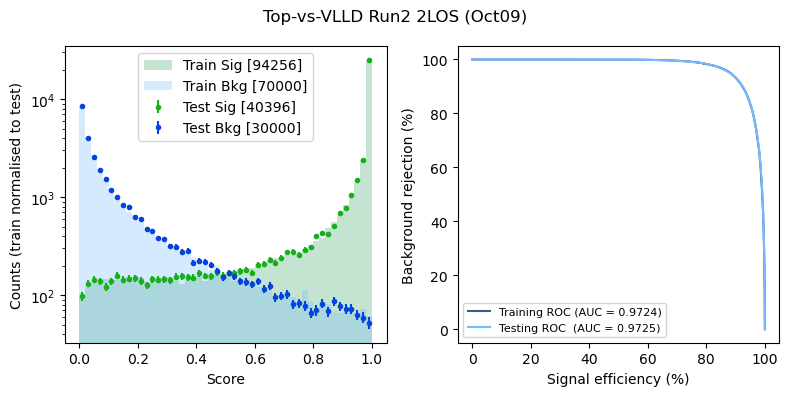

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

decorate_hist = {
    'bins':mybins,
    'histtype':'step',
    'linewidth':1.5,
    'density': density_,
    'log': False,
    'alpha':1.0
}

decorate_point ={
    'marker':'o',
    'markersize':3,
    'linestyle':''
}

if density_:
    ax[0].hist(train_scores_sig, color='xkcd:greenish', label=f'Train Sig [{len(train_scores_sig)}]', alpha=0.3, bins=mybins, density=density_)
    ax[0].hist(train_scores_bkg, color='xkcd:sky blue', label=f'Train Bkg [{len(train_scores_bkg)}]', alpha=0.3, bins=mybins, density=density_)
    ax[0].hist(test_scores_sig,  color='xkcd:green', label=f'Test Sig [{len(test_scores_sig)}]', **decorate_hist)
    ax[0].hist(test_scores_bkg,  color='xkcd:blue',  label=f'Test Bkg [{len(test_scores_bkg)}]',**decorate_hist)

else:
    # Calculate the scaling factors to normalize train histograms to match test integrals
    scale_factor_sig = np.sum(counts_sig_test) / np.sum(counts_sig_train) if np.sum(counts_sig_train) > 0 else 1
    scale_factor_bkg = np.sum(counts_bkg_test) / np.sum(counts_bkg_train) if np.sum(counts_bkg_train) > 0 else 1

    # Make train plots, normalized to match test histogram integrals
    ax[0].hist(train_scores_sig, color='xkcd:greenish', label=f'Train Sig [{len(train_scores_sig)}]', 
               alpha=0.3, bins=mybins, density=False, weights=np.ones_like(train_scores_sig) * scale_factor_sig)
    ax[0].hist(train_scores_bkg, color='xkcd:sky blue', label=f'Train Bkg [{len(train_scores_bkg)}]', 
               alpha=0.3, bins=mybins, density=False, weights=np.ones_like(train_scores_bkg) * scale_factor_bkg)
    
    # Make test plots with error bars
    ax[0].errorbar(bins_sig_test[:-1] + np.diff(bins_sig_test) / 2, 
                   counts_sig_test, 
                   yerr=errors_sig_test, 
                   color='xkcd:green', label=f'Test Sig [{len(test_scores_sig)}]', 
                   fmt='o', markersize=3)
    
    ax[0].errorbar(bins_bkg_test[:-1] + np.diff(bins_bkg_test) / 2, 
                   counts_bkg_test, 
                   yerr=errors_bkg_test, 
                   color='xkcd:blue', label=f'Test Bkg [{len(test_scores_bkg)}]', 
                   fmt='o', markersize=3)

ax[0].set_xlabel('Score')
if density_:     ax[0].set_ylabel('Counts (normalized)')
if not density_: ax[0].set_ylabel('Counts (train normalised to test)')
ax[0].set_yscale('log')
ax[0].legend(loc='best')

ax[1].plot(tpr, fnr, color='xkcd:denim blue', label='Training ROC (AUC = %0.4f)' % auc_score)
ax[1].plot(tpr1,fnr1,color='xkcd:sky blue',   label='Testing ROC  (AUC = %0.4f)'  % auc_score1)
ax[1].set_xlabel('Signal efficiency (%)')
ax[1].set_ylabel('Background rejection (%)')
ax[1].legend(loc='best', fontsize=8)

fig.suptitle(modelname, fontsize=12)

plt.tight_layout()
plt.savefig(f'trained_models/{modelname}/performance.png')
plt.show()

### Permutation importance of the training variables

In [24]:
%%time
import os, sys
import numpy as np
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from functools import partial
from tqdm import tqdm
import io
from contextlib import redirect_stdout, redirect_stderr
import logging

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')

# Custom threshold
nncut = 0.7
n_repeats = 30

# Subset for speed
N = min(5000, len(X_test))
X_eval = X_test[:N]
y_eval = y_test[:N]

# Total iterations for tqdm
total_permutations = n_repeats * X_eval.shape[1]
pbar = tqdm(total=total_permutations, desc="Permutation importance", unit="iter",
            colour="green", ncols=100, leave=True,
            bar_format="{l_bar}{bar}| [{elapsed} < {remaining}, {n_fmt}/{total_fmt}]")

# Scoring function that updates tqdm
def keras_accuracy_base(model, X, y, nncut):
    y_pred = model.predict(X, verbose=0)
    y_pred_classes = (y_pred > nncut).astype(int).flatten()
    acc = accuracy_score(y, y_pred_classes)
    pbar.update(1)
    return acc

# Fix nncut
keras_accuracy = partial(keras_accuracy_base, nncut=nncut)

# Suppress internal prints from sklearn/joblib/TensorFlow
f = io.StringIO()
with redirect_stdout(f), redirect_stderr(f):
    result = permutation_importance(
        model,
        X_eval,
        y_eval,
        n_repeats=n_repeats,
        random_state=42,
        n_jobs=1,
        scoring=keras_accuracy
    )

pbar.close()

Permutation importance: |                                                   | [00:45 < 00:00, 181/?]

CPU times: user 45.2 s, sys: 7.56 s, total: 52.7 s
Wall time: 45.9 s


Sorted Features and Importance Scores:
STvis                0.178633
LTplusMET            0.099140
nbjet                0.051573
STfrac               0.028913
metpt                0.021700
dilep_ptratio        0.016287


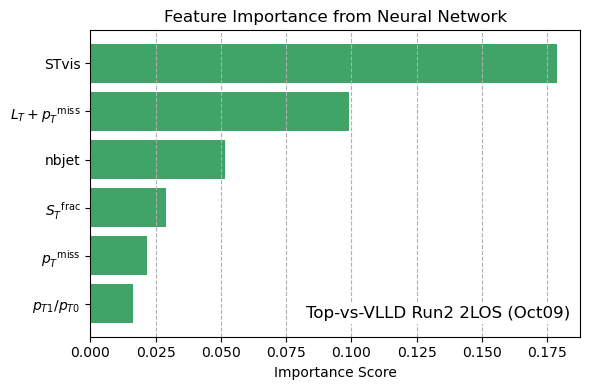

In [25]:
# Get feature importance scores and corresponding variable names
importance_scores = result.importances_mean
feature_names = train_var

# Sort importance scores and corresponding feature names
sorted_indices = np.argsort(importance_scores)[::-1]  # Indices for sorting from most to least
sorted_importance_scores = importance_scores[sorted_indices]
sorted_feature_names = np.array(feature_names)[sorted_indices]
# Apply LaTeX aliases to the sorted feature names
sorted_feature_names_latex = [latexname(name, alias_) for name in sorted_feature_names]

# Print the sorted features and importance scores
print("Sorted Features and Importance Scores:")
for name, score in zip(sorted_feature_names, sorted_importance_scores):  print(f"{name:<20} {score:.6f}")

# Prepare the plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.barh(sorted_feature_names_latex, sorted_importance_scores, color='xkcd:greenish')  # Use LaTeX aliases
ax.invert_yaxis()
ax.set_xlabel('Importance Score')
#ax.set_ylabel('Features')
ax.set_title('Feature Importance from Neural Network')
ax.grid(axis='x', linestyle='--')
ax.text(0.98, 0.05, modelname, transform=ax.transAxes, ha='right', va='bottom', fontsize=12, #fontweight='semibold',
        bbox=dict(facecolor='white', alpha=1.0, edgecolor='none', pad=2))

# Save and show the plot
plt.tight_layout()
plt.savefig(f'trained_models/{modelname}/feature_importance.png', bbox_inches='tight')  # Save with tight bounding box
plt.show()

In [26]:
elapsed = time.time() - notebook_start_time
runtime_str = str(timedelta(seconds=int(elapsed)))
display(HTML(f"<h2>Total notebook runtime: {runtime_str}</h2>"))